In [21]:
import numpy as np
import pandas as pd
import hydra
import torch
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from omegaconf import OmegaConf

from pytorch_lightning import (
    LightningDataModule,
    seed_everything,
)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from tqdm import tqdm

from multimodal_contrastive.analysis.utils import *
from multimodal_contrastive.utils import utils

# register custom resolvers if not already registered
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list), replace=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
sns.set_style("whitegrid")

## How difficult is it to find molecules that produce similar morphological profile to the target?

We investigate by plotting a histogram of cosine distances between the joint target/morph latent and the struct latent of all molecules in the dataset.

In [2]:
config_name = "puma_sm_gmc"
configs_path = "../multimodal_contrastive/configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

cfg.datamodule.split_type

'shuffled_scaffold'

In [3]:
# set seed for random number generators in pytorch, numpy and python.random
# and especially for generating the same data splits for the test set
if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)

In [4]:
# Load test data split
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


Train on samples from shuffled_scaffold.
Train on 13568 samples.
Validate on 1696 samples.
Test on 1697 samples.


In [5]:
# Get the raw morphology features
test_loader = datamodule.infer_dataloader()
loader = make_eval_data_loader(datamodule.dataset)
train_idx, val_idx, test_idx = datamodule.get_split_idx()
mods = unroll_dataloader(loader, mods=['morph'])
morph = mods['morph']

/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 133/133 [00:38<00:00,  3.47it/s]


In [17]:
# Load model from checkpoint
# ckpt_path = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/morph_struct.ckpt"
# ckpt_path = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/models/epoch=72-step=7738.ckpt"
ckpt_path = "/home/mila/s/stephen.lu/scratch/mmc/omics-guided-gfn/lnbstu57/checkpoints/epoch=19-step=2340.ckpt"
# ckpt_path = "/home/mila/s/stephen.lu/scratch/mmc/omics-guided-gfn/bmw9vp7a/checkpoints/epoch=120-step=14157.ckpt"
# ckpt_path = "/home/mila/s/stephen.lu/scratch/mmc/omics-guided-gfn/05tjweok/checkpoints/epoch=22-step=2438.ckpt"
model = utils.instantiate_model(cfg)
model = model.load_from_checkpoint(ckpt_path, map_location=device)
model = model.eval()

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was prod

In [7]:
# Get latent representations for full dataset
representations, mols = model.compute_representation_dataloader(
    loader,
    device=device,
    return_mol=True
)

100%|██████████| 133/133 [00:58<00:00,  2.27it/s]


In [8]:
# save_representations(representations, mols, "puma_embeddings.npz")

In [18]:
# Get latent representations for test dataset
representations_test, mols_test = model.compute_representation_dataloader(
    test_loader,
    device=device,
    return_mol=True
)

  0%|          | 0/14 [00:00<?, ?it/s]/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 14/14 [00:07<00:00,  1.91it/s]


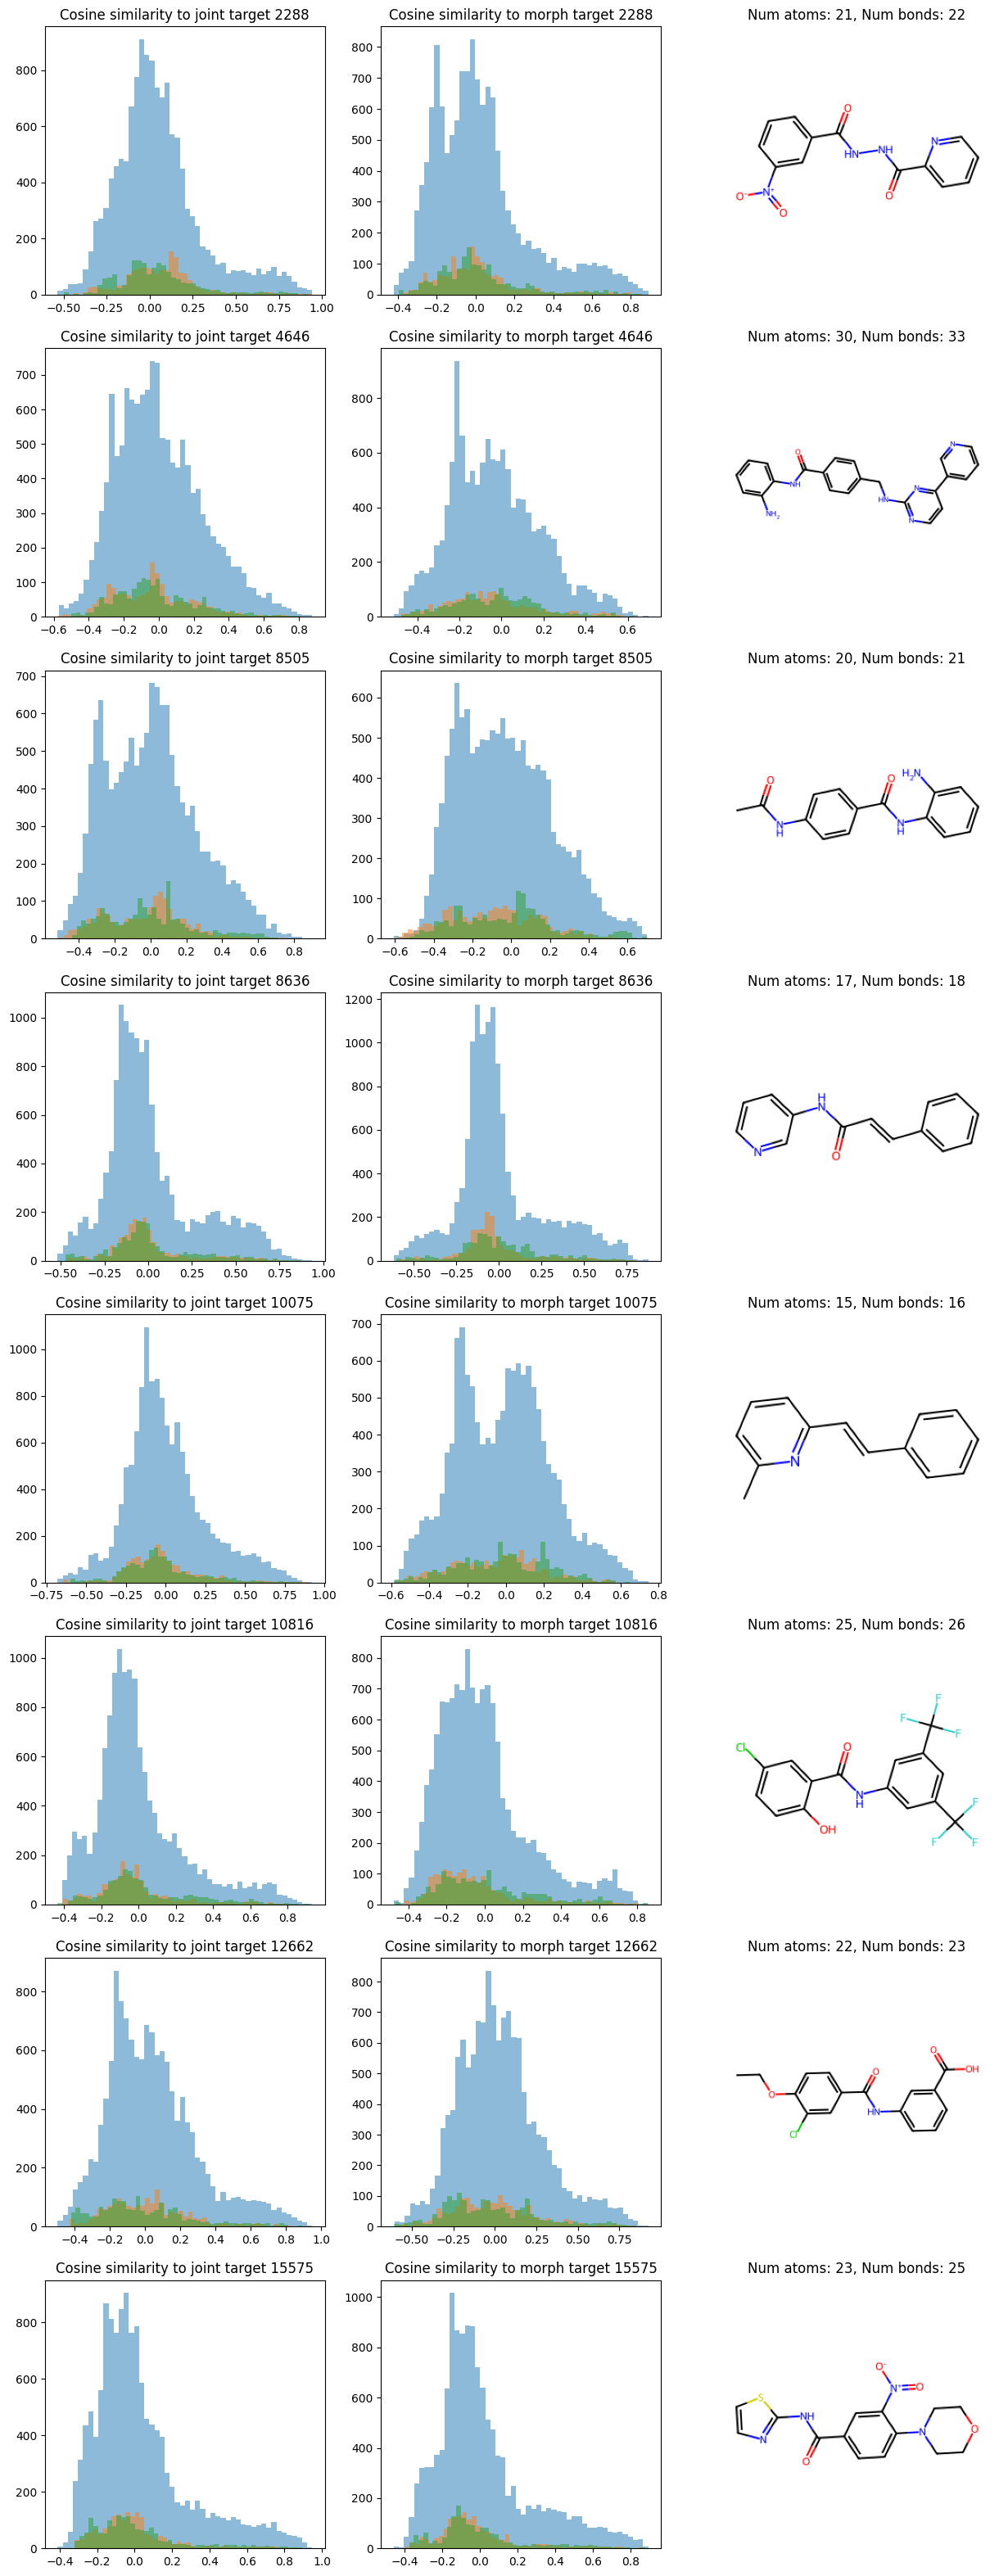

In [9]:
struct_latents_train = representations['struct'][train_idx]
struct_latents_val = representations['struct'][val_idx]
struct_latents_test = representations['struct'][test_idx]

struct_latents = {
    "train": struct_latents_train,
    "val": struct_latents_val,
    "test": struct_latents_test
}

target_indices = [2288, 4646, 8505, 8636, 10075, 10816, 12662, 15575]
# target_indices = [3608, 16162]
# target_indices = [15907, 16487, 15769, 8899, 7446]
n_targets = len(target_indices)
# n_targets = 5

fig, ax = plt.subplots(n_targets, 3, figsize=(15, 5*n_targets))

for i in range(n_targets):
    # get a random target molecule and its latent representations
    target_idx = target_indices[i]
    # target_idx = np.random.choice(test_idx)
    # assert target_idx in test_idx

    target_joint_latent = representations['joint'][target_idx]
    target_morph_latent = representations['morph'][target_idx]
    # target_joint_latent = representations_test['joint'][target_idx]
    # target_morph_latent = representations_test['morph'][target_idx]

    for j, split in enumerate(["train", "val", "test"]):
        struct_latents_split = struct_latents[split]

        # compute cosine similarity between target and all struct latents
        cosine_sim_joint = cosine_similarity([target_joint_latent], struct_latents_split)
        cosine_sim_morph = cosine_similarity([target_morph_latent], struct_latents_split)

        # plot histogram of cosine sim
        ax[i, 0].hist(cosine_sim_joint.flatten(), bins=50, alpha=0.5, label=split)
        ax[i, 1].hist(cosine_sim_morph.flatten(), bins=50, alpha=0.5, label=split)

    ax[i, 0].set_title(f"Cosine similarity to joint target {target_idx}")
    ax[i, 1].set_title(f"Cosine similarity to morph target {target_idx}")

    # plot the target molecule
    mol = mols[target_idx]
    mol = Chem.MolFromSmiles(mol)
    img = Draw.MolToImage(mol)
    
    num_atoms = mol.GetNumAtoms()
    num_bonds = mol.GetNumBonds()

    ax[i, 2].set_title(f"Num atoms: {num_atoms}, Num bonds: {num_bonds}")
    ax[i, 2].imshow(img)
    ax[i, 2].axis("off")

    # save the target instance
    sample = loader.dataset[target_idx]
    struct = sample["inputs"]["struct"]
    smiles = struct.mols

    with open(f"sample_{target_idx}.pkl", "wb") as f:
        pickle.dump(sample, f)
    
    with open(f"sample_{target_idx}.txt", "wb") as f:
        f.write(smiles)

plt.show()

## Get summary statistics about the molecules in the training dataset
I want to get statistics on number of nodes, number of edges, and types of fragments on the molecules in the dataset. This will guide the hyperparameters that we set on the gflownet.

In [ ]:
datasets = {
    "train": train_idx,
    "val": val_idx,
    "test": test_idx
}

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for split in ["train", "val", "test"]:
    num_edges = []
    num_nodes = []

    for idx in datasets[split]:
        mol = mols[idx]
        mol = Chem.MolFromSmiles(mol)

        num_atoms = mol.GetNumAtoms()
        num_bonds = mol.GetNumBonds()

        num_nodes.append(num_atoms)
        num_edges.append(num_bonds)

    ax[0].hist(num_edges, bins=50, alpha=0.5, label=split)
    ax[1].hist(num_nodes, bins=50, alpha=0.5, label=split)

ax[0].set_title("Number of edges in molecules")
ax[1].set_title("Number of nodes in molecules")

plt.show()

In [ ]:
# Now let's take a look at what the fragments in the gflownet frag building env look like
from gflownet.models import bengio2021flow

smi, stems = zip(*bengio2021flow.FRAGMENTS)

num_atoms = []
num_edges = []

for smile in smi:
    mol = Chem.MolFromSmiles(smile)
    num_atoms.append(mol.GetNumAtoms())
    num_edges.append(mol.GetNumBonds())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(num_atoms, bins=25)
ax[0].set_title("Number of atoms per fragment")
ax[0].set_xlabel("Number of atoms")
ax[0].set_ylabel("Count (#fragments)")

ax[1].hist(num_edges, bins=25)
ax[1].set_title("Number of edges per fragment")
ax[1].set_xlabel("Number of edges")
ax[1].set_ylabel("Count (#fragments)")

# Add vertical bar for mean
mean_atoms = np.mean(num_atoms)
mean_edges = np.mean(num_edges)

ax[0].axvline(mean_atoms, color='r', linestyle='--', label=f"Mean: {mean_atoms:.2f}")
ax[1].axvline(mean_edges, color='r', linestyle='--', label=f"Mean: {mean_edges:.2f}")

ax[0].legend()
ax[1].legend()

plt.show()

In [8]:
keys = [   39,   338,   903,  1847,  2288,  4331,  6888,  8206,  8838,  8949,
        9277,  9300,  9445,  9476, 10075, 12071, 13905]

for sample_idx in keys:
    # assert sample_idx in test_idx
    sample = datamodule.dataset[sample_idx]
    struct_latent = representations['struct'][sample_idx]
    morph_latent = representations['morph'][sample_idx]
    joint_latent = representations['joint'][sample_idx]
    
    print(
        sample_idx,
        cosine_similarity(struct_latent.reshape(1, -1), morph_latent.reshape(1, -1)),
        cosine_similarity(struct_latent.reshape(1, -1), joint_latent.reshape(1, -1)),
        cosine_similarity(morph_latent.reshape(1, -1), joint_latent.reshape(1, -1))
    )

39 [[0.48036456]] [[0.9193298]] [[0.5960577]]
338 [[0.08416305]] [[0.88583714]] [[0.35768402]]
903 [[0.45698345]] [[0.9567528]] [[0.63815033]]
1847 [[0.16040224]] [[0.95529324]] [[0.269818]]
2288 [[0.72375035]] [[0.93877786]] [[0.81551504]]
4331 [[-0.33291197]] [[0.93131626]] [[-0.09960501]]
6888 [[0.22609639]] [[0.90282863]] [[0.4882638]]
8206 [[-0.11188747]] [[0.91880214]] [[0.15454614]]
8838 [[0.6055174]] [[0.8084939]] [[0.8317271]]
8949 [[0.16585147]] [[0.8484664]] [[0.29815197]]
9277 [[0.64228374]] [[0.9015377]] [[0.7432953]]
9300 [[0.12547535]] [[0.86142755]] [[0.48697382]]
9445 [[0.4038251]] [[0.95098704]] [[0.47925556]]
9476 [[0.6902788]] [[0.95745754]] [[0.8184377]]
10075 [[0.09193264]] [[0.42322147]] [[0.7206311]]
12071 [[0.49500018]] [[0.7533977]] [[0.84723455]]
13905 [[0.2532935]] [[0.67281324]] [[0.5743401]]


In [19]:
# For all test samples, we compute the cosine similarity between the struct and morph latents
# and the struct and joint latents, then save to a file
struct_morph_sim_test = cosine_similarity(representations_test['struct'], representations_test['morph'])
struct_joint_sim_test = cosine_similarity(representations_test['struct'], representations_test['joint'])

In [20]:
# Only keep the diagonal elements which correspond to the similarity between the same sample's latents
struct_morph_sim_test = np.diag(struct_morph_sim_test)
struct_joint_sim_test = np.diag(struct_joint_sim_test)

np.save("cross-corr-model-struct-morph-sim.npy", struct_morph_sim_test)
np.save("cross-corr-model-struct-joint-sim.npy", struct_joint_sim_test)

In [4]:
savedir = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/data/"

In [5]:
val_loss_morph_sim = np.load(f"{savedir}/val-loss-model-struct-morph-sim.npy")
val_loss_joint_sim = np.load(f"{savedir}/val-loss-model-struct-joint-sim.npy")
cross_corr_morph_sim = np.load(f"{savedir}/cross-corr-model-struct-morph-sim.npy")
cross_corr_joint_sim = np.load(f"{savedir}/cross-corr-model-struct-joint-sim.npy")

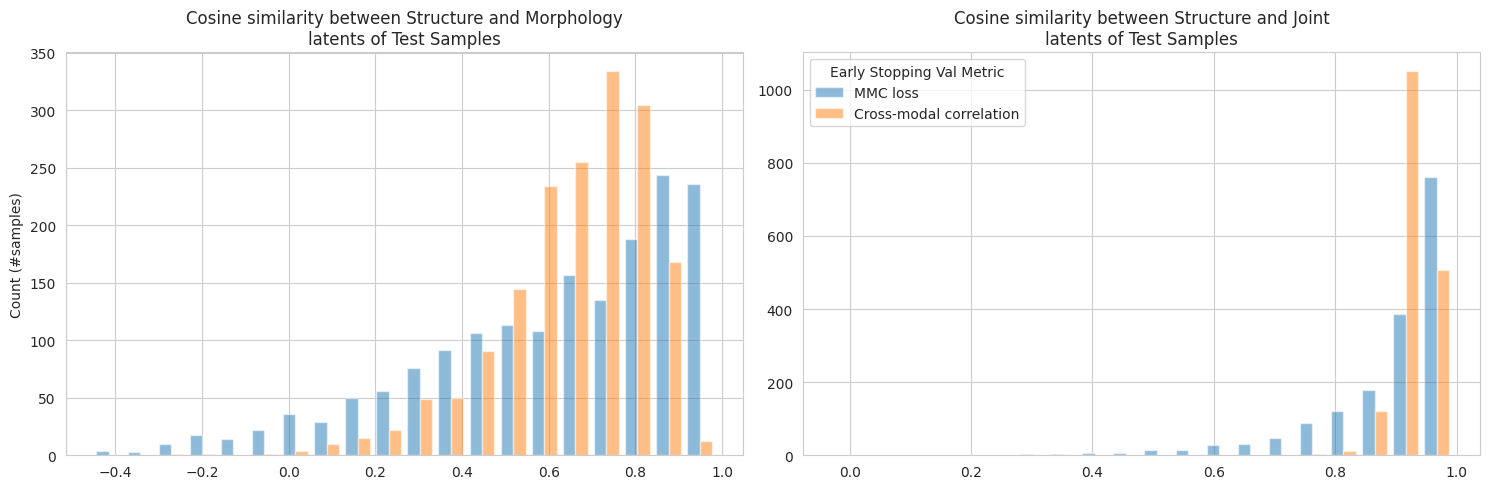

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist([val_loss_morph_sim, cross_corr_morph_sim], bins=20, alpha=0.5, label=["MMC loss", "Cross-modal correlation"])
ax[0].set_title("Cosine similarity between Structure and Morphology\nlatents of Test Samples")
ax[0].set_ylabel("Count (#samples)")
# ax[0].legend(title="Early Stopping Val Metric")

ax[1].hist([val_loss_joint_sim, cross_corr_joint_sim], bins=20, alpha=0.5, label=["MMC loss", "Cross-modal correlation"])
ax[1].set_title("Cosine similarity between Structure and Joint\nlatents of Test Samples")
ax[1].legend(title="Early Stopping Val Metric")

plt.tight_layout()
plt.savefig("earlystopping-val-metric-hist-comparison.pdf", dpi=300, format="pdf")
# plt.show()

In [13]:
df = pd.DataFrame({
    "Early Stopping Val Metric": np.concatenate([["MMC loss"]*len(val_loss_morph_sim), ["Cross-modal correlation"]*len(cross_corr_morph_sim)]),
    "struct_morph": np.concatenate([val_loss_morph_sim, cross_corr_morph_sim]),
    "struct_joint": np.concatenate([val_loss_joint_sim, cross_corr_joint_sim]),
})

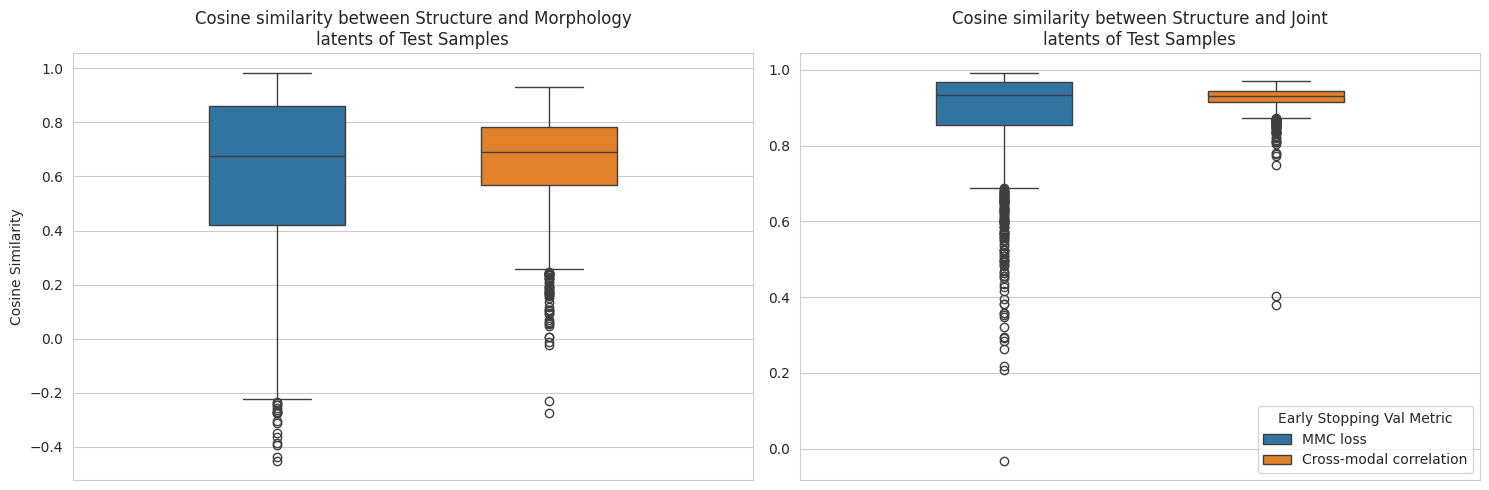

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, hue="Early Stopping Val Metric", y="struct_morph", ax=ax[0], gap=0.5, legend=False)
sns.boxplot(data=df, hue="Early Stopping Val Metric", y="struct_joint", ax=ax[1], gap=0.5)

ax[0].set_title("Cosine similarity between Structure and Morphology\nlatents of Test Samples")
ax[1].set_title("Cosine similarity between Structure and Joint\nlatents of Test Samples")
ax[1].set_ylabel("")
ax[0].set_ylabel("Cosine Similarity")

# plt.legend(title="Early Stopping Val Metric")

plt.tight_layout()
plt.savefig("earlystopping-val-metric-boxplot-comparison.pdf", dpi=300, format="pdf")